IMPORTING NESECARRY LIBRARIES


In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
  
%matplotlib inline 

In [2]:
from google.colab import drive
drive.mount('/content/drive')
train_data = pd.read_csv('/content/drive/MyDrive/MachineLearningProject/datasets/HAR_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/MachineLearningProject/datasets/HAR_test.csv')

Mounted at /content/drive


In [3]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 31.6+ MB


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2947 entries, 0 to 2946
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 12.7+ MB


In [5]:
def plot_activity(df):
    label_counts = df['Activity'].value_counts()
    D = dict(label_counts)
    x,y = [val for val in D],[D[val] for val in D]
    Dic = {"activity" : x,"counts" : y}
    data = pd.DataFrame(Dic)
    data.plot.bar(x="activity",y="counts",title="counts on human activity");

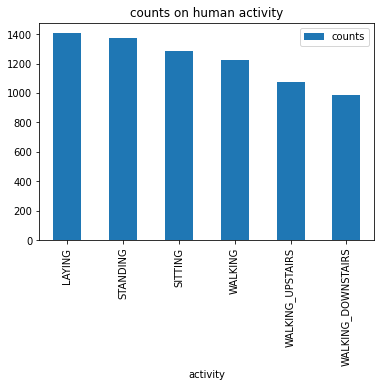

In [6]:
#train data
train_data.shape
train_data.head(5)
train_data.describe()
train_data.isnull().any()#checking for null values
plot_activity(train_data)    

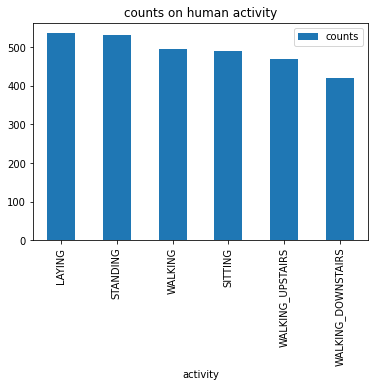

In [7]:
#test data
test_data.shape
test_data.head(5)
test_data.describe()
test_data.isnull().any()
plot_activity(test_data)    

CONCATINATION OF TRAIN AND TEST DATA


tBodyAcc-mean()-X  tBodyAcc-mean()-Y  ...  subject  Activity
0           0.288585          -0.020294  ...        1  STANDING
1           0.278419          -0.016411  ...        1  STANDING
2           0.279653          -0.019467  ...        1  STANDING
3           0.279174          -0.026201  ...        1  STANDING
4           0.276629          -0.016570  ...        1  STANDING

[5 rows x 563 columns]

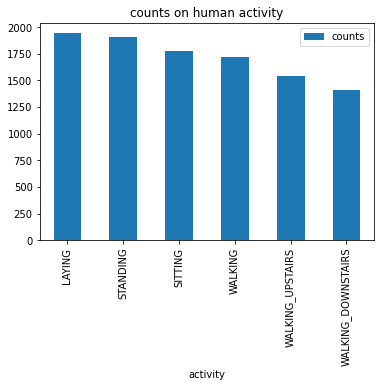

In [8]:
Net_Data = pd.concat([train_data,test_data], axis = 0).reset_index(drop=True)
Net_Data.shape
#concatination of two datasets
plot_activity(Net_Data)
Net_Data.head(5)
#Net_Data.describe()

DATA PREPROCESSING

In [9]:
#univariate outlier detection
class detect_outlier:
  def __init__(self,Net_Data):
    self.major_list = []
    self.IQR = []
    self.outlier = {Net_Data.columns[x] : [] for x in range(Net_Data.shape[1] - 2)}
    self.dataset = Net_Data
  def store_percentiles(self):  
      for col_val in range(self.dataset.shape[1] - 2):
          minor_list = list(self.dataset.iloc[:,col_val].describe())[4:7:2]
          self.major_list.append(minor_list)
      return self.major_list
  def calc_IQR(self):
      self.IQR = [1.5 * (self.major_list[i][1] - self.major_list[i][0]) for i in range(len(self.major_list))] 
      return self.IQR
  def limits(self):
      self.lowval,self.highval = [],[]
      Q1,Q3 = [self.major_list[i][0] for i in range(len(self.major_list))],[self.major_list[j][1] for j in range(len(self.major_list))]    
      for i in range(len(self.major_list)):
          self.lowval.append(Q1[i] - self.IQR[i])
          self.highval.append(Q3[i] + self.IQR[i])
      return "the lowvalues and highvalues are ",list(zip(self.lowval,self.highval)) 
  def Toutliers(self):
      self.sub_list = []
      for feature_index in range(self.dataset.shape[1] - 2):
          self.sub_list = [values for values in self.dataset.iloc[:,feature_index] if ((values < self.lowval[feature_index]) or (values > self.highval[feature_index]))]               
          self.outlier[self.dataset.columns[feature_index]].append(self.sub_list)    
      return self.outlier      
obj = detect_outlier(Net_Data)
obj.store_percentiles()
obj.calc_IQR()             
obj.limits()

('the lowvalues and highvalues are ',
 [(0.2240306500000001, 0.3269483699999999),
  (-0.04631935749999999, 0.010792318499999991),
  (-0.15616318024999998, -0.062445046250000025),
  (-2.105461935, 0.8628085849999998),
  (-2.3564722267500002, 1.32214643125),
  (-2.029736285, 0.7718619949999999),
  (-2.0301842925, 0.7348585675),
  (-2.3114346992500003, 1.24701357875),
  (-2.0154359375, 0.7482231225000001),
  (-2.31751015725, 1.36708108875),
  (-1.3054077839999998, 0.67549324),
  (-1.512098555, 0.3543127649999999),
  (-0.7343655849999999, 1.7906880149999997),
  (-0.7430393000000001, 1.5421333400000001),
  (-0.27331906, 1.5027778999999999),
  (-2.270021495, 1.165485785),
  (-1.4262065274999998, -0.2894676675000003),
  (-1.2617049000000002, -0.5632158199999999),
  (-1.3593254725000001, -0.39956073249999985),
  (-1.8736099924999998, 0.47152306749999984),
  (-1.96633702, 0.66035734),
  (-1.9416306975, 0.6267504024999999),
  (-1.90396516, 1.6697178799999999),
  (-1.7987405625, 1.532270457500000

In [10]:
#no of outliers present in all features of dataset
#there are more than 30% outliers in the dataset
outliers_dict = obj.Toutliers()
def remove_duplicates(outliers_dict):
    for i in range(len(outliers_dict)):
        outliers_dict[Net_Data.columns[i]] = outliers_dict[Net_Data.columns[i]][:1]
    return outliers_dict
outliers_dict = remove_duplicates(outliers_dict) 
#print("outliers : ",outliers_dict['tBodyAcc-mean()-X'][0])   
print("No of outliers in tBodyAcc-mean()-X feature is ",len(outliers_dict['tBodyAcc-mean()-X'][0])) 

No of outliers in tBodyAcc-mean()-X feature is  2437


In [11]:
count = {item: len(value[0]) for (item, value) in outliers_dict.items()}
def bar_plots(first,last):
    fig = plt.figure(figsize=(20,10))
    xaxis,yaxis = list(count.keys())[first:last],list(count.values())[first:last]
    plt.bar(xaxis,yaxis,color='maroon',width=0.2)
    plt.xlabel("FEATURES")
    plt.ylabel("NO OF OUTLIERS")
    plt.title("FEATURES ACCORDING TO OUTLIERS")
    plt.show()
bar_plots(553,561)    

In [12]:
#checking for duplicate rows
def duplicates_removal(df):
    duplicates = df.duplicated()
    print(duplicates.any())
duplicates_removal(Net_Data) 

False


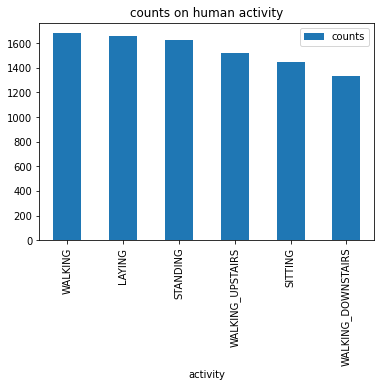

In [13]:
#removing rows with outliers
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = clf.fit_predict(Net_Data.iloc[:,:-1])
outlier_index = np.where(y_pred==-1)
for i in outlier_index:
    Net_Data = Net_Data.drop(Net_Data.index[i])
    Net_Data = Net_Data.reset_index(drop=True)
Net_Data.describe()
plot_activity(Net_Data)    

In [14]:
Net_Data.info()
len(outlier_index[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9269 entries, 0 to 9268
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 39.8+ MB


1030

DATA ANALYSIS

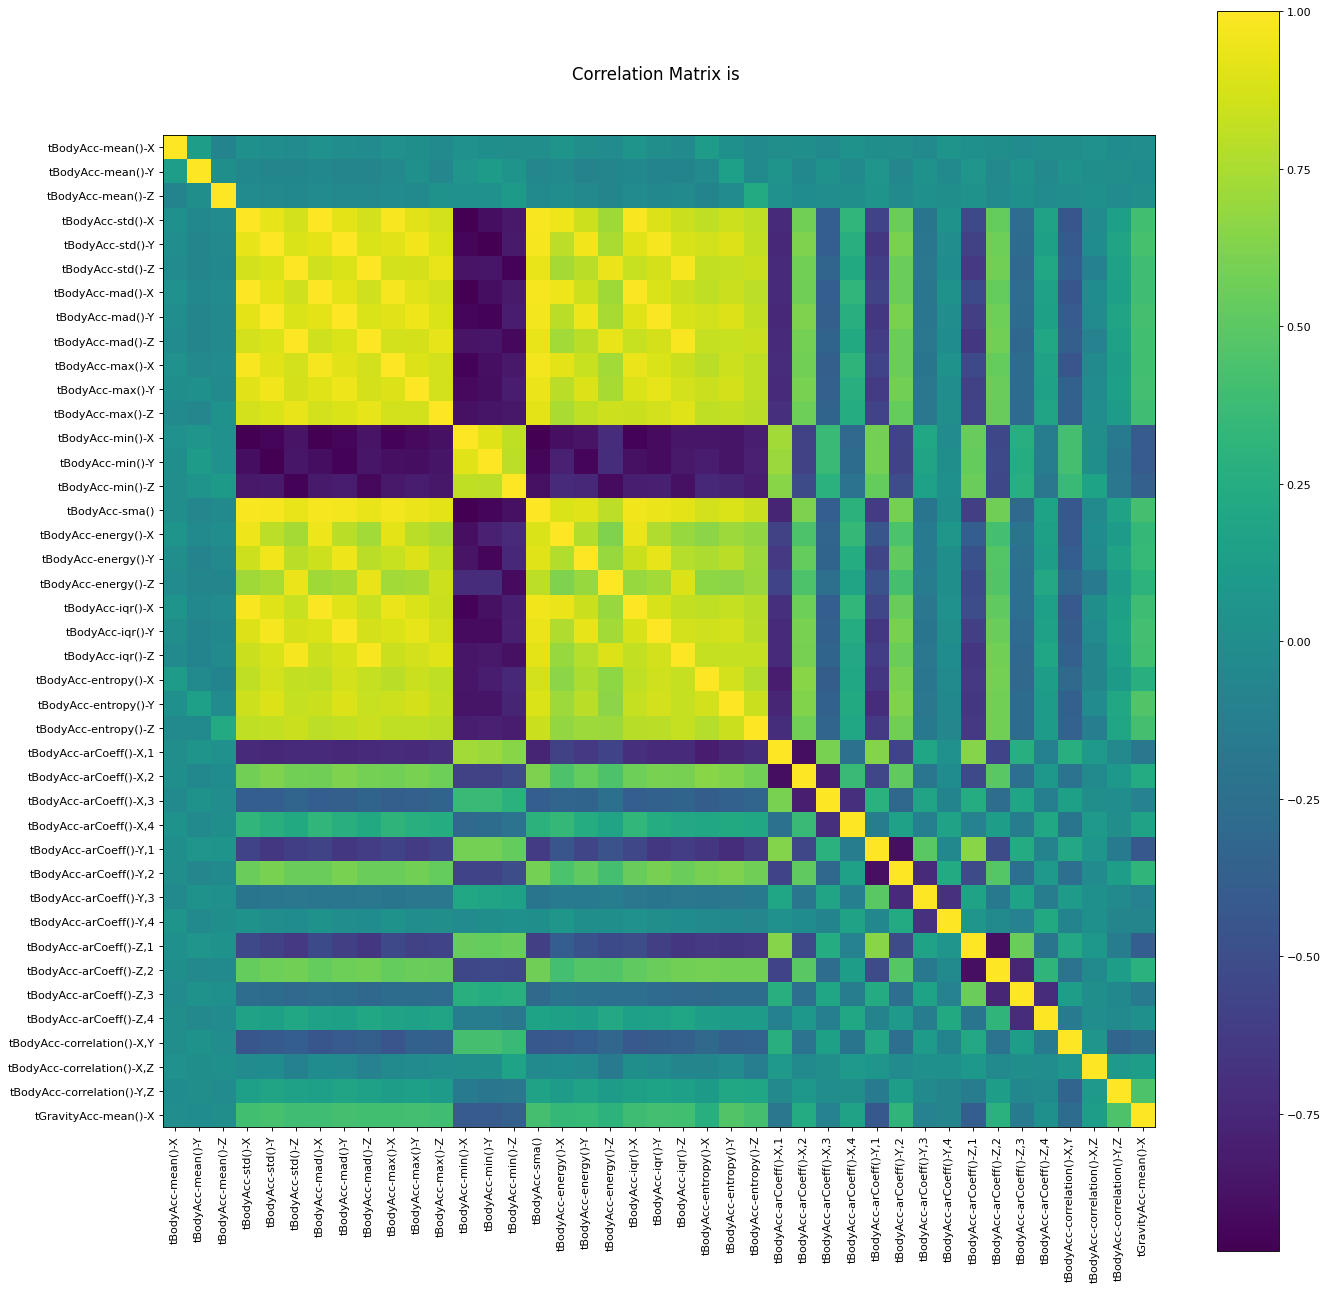

In [15]:
#correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title('Correlation Matrix is ', fontsize=15)
    plt.show()
plotCorrelationMatrix(Net_Data.iloc[:,0:41],20)    

In [16]:
#ANOVA feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
def ANOVA(X_train,Y_train,X_test):
  fs = SelectKBest(score_func=f_classif,k = 'all')
  fs.fit(X_train,Y_train)
  X_train_fs = fs.transform(X_train)
  X_test_fs = fs.transform(X_test)
  return X_train_fs,X_test_fs,fs

In [17]:
#segregation of data according to target variable for visualization
def segregate_data(Net_Data,S):
  D = Net_Data[Net_Data['Activity'].str.contains(S)]
  return D
data_laying = segregate_data(Net_Data,"LAYING")
data_walking = segregate_data(Net_Data,"WALKING")
data_standing = segregate_data(Net_Data,"STANDING")
data_sitting = segregate_data(Net_Data,"SITTING")
data_walking_upstairs = segregate_data(Net_Data,"WALKING_UPSTAIRS")
data_walking_downstairs = segregate_data(Net_Data,"WALKING_DOWNSTAIRS") 

In [18]:
#data visualization using plotly
import plotly.express as px
fig1 = px.scatter_3d(data_walking,x= 'tBodyAcc-std()-X',y='tBodyAcc-std()-Y',z='tBodyAcc-std()-Z')
fig2 = px.scatter_3d(data_walking,x = 'tBodyAcc-mean()-X',y = 'tBodyAcc-mean()-Y',z = 'tBodyAcc-mean()-Z')
fig3 = px.scatter_3d(data_walking,x = 'tBodyAcc-max()-X',y = 'tBodyAcc-max()-Y',z = 'tBodyAcc-max()-Z')
fig1.show()

In [19]:
#label encoding
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
Net_Data['Activity'] = label_encoder.fit_transform(Net_Data['Activity'])
Net_Data['Activity'].unique()
#removing unnesecary colomns
Net_Data = Net_Data.drop(columns=['subject'])
Net_Data.head(5)

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  ...  angle(Z,gravityMean)  Activity
0           0.278419          -0.016411  ...             -0.054317         2
1           0.279653          -0.019467  ...             -0.049118         2
2           0.279174          -0.026201  ...             -0.047663         2
3           0.276629          -0.016570  ...             -0.043892         2
4           0.277199          -0.010098  ...             -0.042126         2

[5 rows x 562 columns]

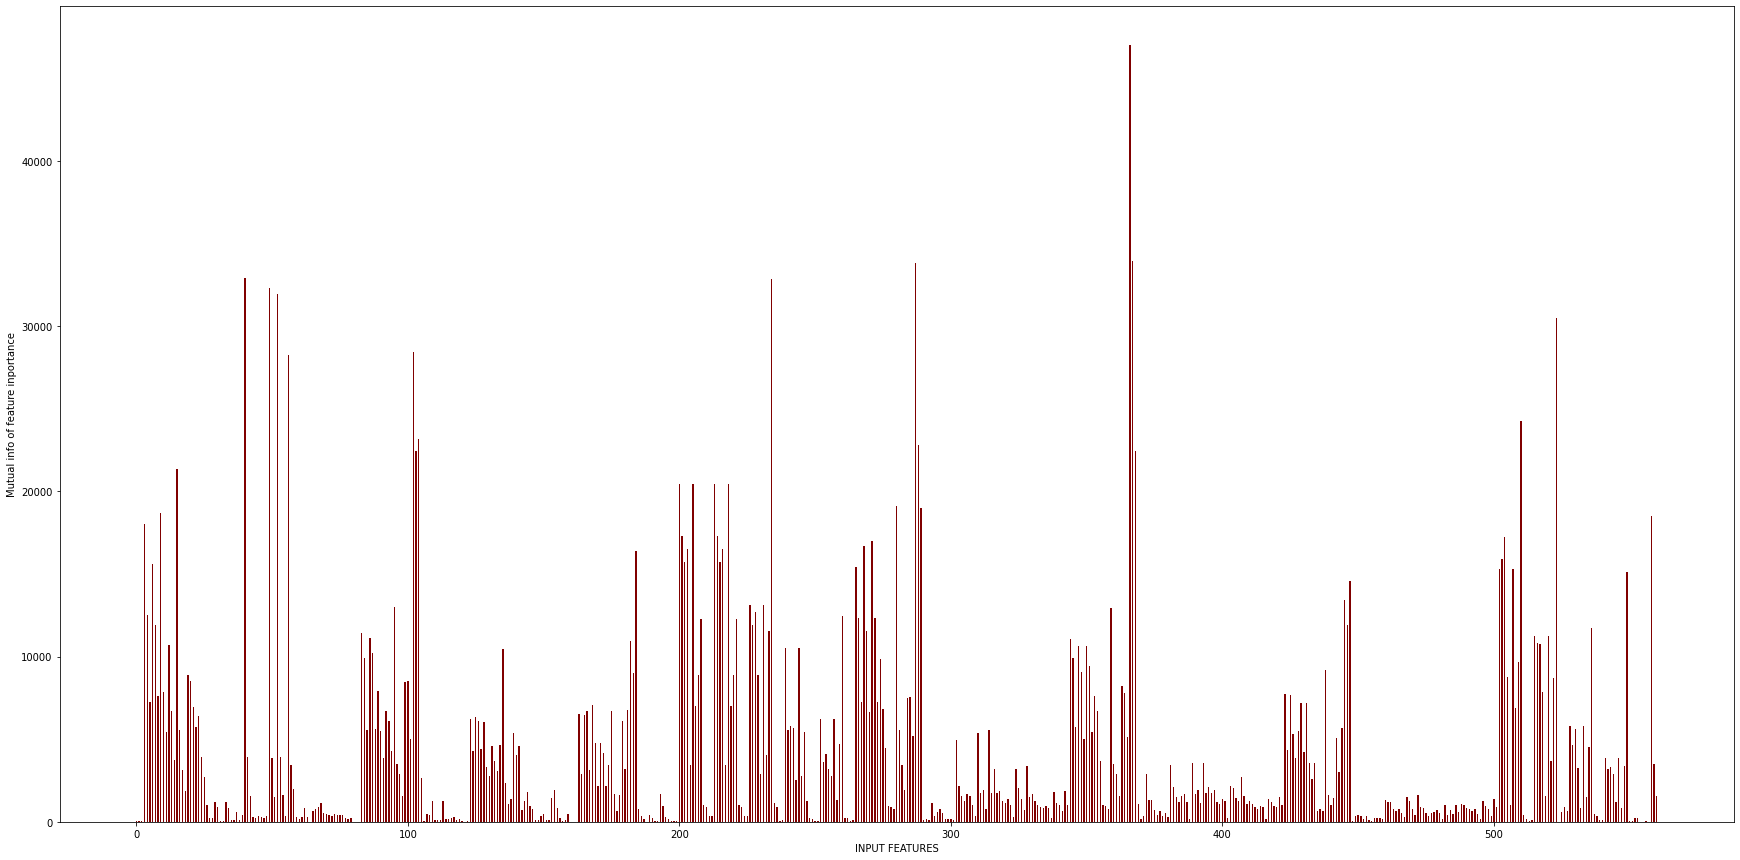

In [20]:
#seperating independent and dependant variables
X = Net_Data.iloc[:,:-1].values
Y = Net_Data.iloc[:,-1].values
#splitting the dataset into train and test
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.25,random_state=0)
#feature selection
X_train,X_test,fs = ANOVA(X_train,Y_train,X_test)
feature_scores = [(i,fs.scores_[i]) for i in range(len(fs.scores_))]
fig = plt.figure(figsize=(30,15))
plt.bar([i for i in range(len(fs.scores_))],fs.scores_,width=0.5,color='maroon')
plt.xlabel("INPUT FEATURES")
plt.ylabel("Mutual info of feature inportance")
plt.show()

In [21]:
feature_scores
#modified data
MNet_Data = Net_Data
MNet_Data

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  ...  angle(Z,gravityMean)  Activity
0              0.278419          -0.016411  ...             -0.054317         2
1              0.279653          -0.019467  ...             -0.049118         2
2              0.279174          -0.026201  ...             -0.047663         2
3              0.276629          -0.016570  ...             -0.043892         2
4              0.277199          -0.010098  ...             -0.042126         2
...                 ...                ...  ...                   ...       ...
9264           0.310155          -0.053391  ...              0.184784         5
9265           0.363385          -0.039214  ...              0.182412         5
9266           0.349966           0.030077  ...              0.181184         5
9267           0.237594           0.018467  ...              0.187563         5
9268           0.153627          -0.018437  ...              0.188103         5

[9269 rows x 562 columns]

In [22]:
fscores_min = [i for i in feature_scores if i[1] < 70]
fscores_max = [i for i in feature_scores if i[1] > 20000]
cols = [i[0] for i in fscores_min]
#feature reduction
MNet_Data.drop(Net_Data.columns[cols],inplace=True,axis=1)
MNet_Data = MNet_Data.reset_index(drop=True)
X = MNet_Data.iloc[:,:-1]
Y = MNet_Data.iloc[:,-1]

TRAIN TEST SPLIT

In [23]:
#train test split for modifier data
MX_train,MX_test,MY_train,MY_test = train_test_split(X,Y,test_size=0.25,random_state=0)
MX_train = MX_train.reset_index(drop=True)
MX_test = MX_test.reset_index(drop=True)
print("No of features removed is ",len(fscores_min))

No of features removed is  35


In [24]:
#feature scaling
from sklearn.preprocessing import StandardScaler
st_x = StandardScaler()
MX_train=st_x.fit_transform(MX_train)
MX_test = st_x.transform(MX_test)

In [25]:
from sklearn.svm import SVC
classifier = SVC(kernel='rbf',random_state=0,gamma='scale')
classifier.fit(MX_train,MY_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

METRICS

In [26]:
#prediction of test result
y_pred = classifier.predict(MX_train)
#confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(MY_train,y_pred)
cm
from sklearn.metrics import accuracy_score
accuracy_score(MY_train,y_pred)

0.9837433462811106

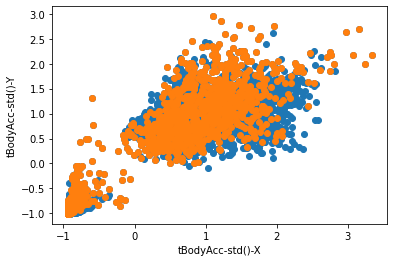

array([[-0.85343796, -0.9293036 , -0.93267545, ...,  1.97499533,
         1.08697526, -2.90718488],
       [-0.87271696, -0.92973473, -0.93469029, ...,  1.86925476,
        -1.85816652, -1.75017364],
       [-0.84628591, -0.85185705, -0.71457235, ...,  2.45971496,
         1.05876405,  3.42339583],
       ...,
       [ 0.71720158,  0.40029743,  0.95570457, ...,  0.19510205,
         1.16803926,  1.12444679],
       [ 1.50221479,  1.56821067,  1.57253562, ..., -0.21254255,
         0.85254778,  0.72962152],
       [ 1.06198556,  1.25953726,  0.66814856, ..., -0.55651376,
         0.56211443,  0.313229  ]])

In [27]:
Xdf = pd.DataFrame(X_train)
plt.scatter(MX_train[:,0],MX_train[:,1],cmap='autumn')
plt.scatter(classifier.support_vectors_[:,0],classifier.support_vectors_[:,1])
plt.xlabel('tBodyAcc-std()-X')
plt.ylabel('tBodyAcc-std()-Y')
plt.show()
classifier.n_support_
classifier.support_vectors_

In [28]:
from sklearn.model_selection import KFold
import numpy as np
acc_score = []

kf = KFold(n_splits=5)

for train_index, test_index in kf.split(X,Y):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

    classifier.fit(X_train,Y_train)
    predictions = classifier.predict(X_test)
    acc_score.append(accuracy_score(predictions, Y_test))

np.mean(acc_score)

0.9418495678310516

TESTING THE MODEL

In [29]:
#inverse transform for dataset used in training
print("the catogerical values for values (0,1,2,3,4,5) respectively is",label_encoder.inverse_transform([0,1,2,3,4,5]))

the catogerical values for values (0,1,2,3,4,5) respectively is ['LAYING' 'SITTING' 'STANDING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']


In [30]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
#new data samples
column = pd.read_csv('/content/drive/MyDrive/MachineLearningProject/datasets/features_temp1.csv',encoding='unicode_escape',header=None)
column = list(column.iloc[:,-1])
sample_dataset = pd.read_csv('/content/drive/MyDrive/MachineLearningProject/datasets/UCI_train_temp.csv',encoding='unicode_escape',header=None)
output_dataset = pd.read_csv('/content/drive/MyDrive/MachineLearningProject/datasets/dataset_uci/final_y_train.txt',header=None)
sample_dataset.columns = column
sample_dataset.info()
sample_dataset.isnull().sum()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4252 entries, 0 to 4251
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(560), object(1)
memory usage: 18.2+ MB


tBodyAcc-mean()-X                       0
tBodyAcc-mean()-Y                       0
tBodyAcc-mean()-Z                       0
tBodyAcc-std()-X                        0
tBodyAcc-std()-Y                        0
                                       ..
angle(tBodyGyroMean,gravityMean)        0
angle(tBodyGyroJerkMean,gravityMean)    0
angle(X,gravityMean)                    0
angle(Y,gravityMean)                    0
angle(Z,gravityMean)                    0
Length: 561, dtype: int64

In [32]:
new_input = sample_dataset.iloc[1,:]
indexes = set([i[0] for i in feature_scores])
unwanted_indexes = set([i[0] for i in fscores_min])
indexes = list(indexes - unwanted_indexes)
print("no of columns in sample is ",len(indexes))
new_input = new_input[indexes]

no of columns in sample is  526


In [33]:
#There are 10,299 samples in the dataset
def verify(input_sample,output):
    input_sample = input_sample.reshape(1,-1)
    y_predict = classifier.predict(input_sample) 
    print("the predicted value is ",label_encoder.inverse_transform(y_predict))
    print("the actual value is ",label_encoder.inverse_transform([output]))
#for 10th sample    
verify(MX_test[10],MY_test.iloc[10])
#for 178th sample 
verify(MX_test[178],MY_test.iloc[178])
#for 201th sample 
verify(MX_test[201],MY_test.iloc[201])  

the predicted value is  ['STANDING']
the actual value is  ['STANDING']
the predicted value is  ['LAYING']
the actual value is  ['SITTING']
the predicted value is  ['WALKING_DOWNSTAIRS']
the actual value is  ['WALKING_DOWNSTAIRS']


In [34]:
saved_model = pickle.dumps(classifier)
svm_from_pickle = pickle.loads(saved_model)
svm_from_pickle.predict(MX_test)

array([0, 4, 0, ..., 4, 2, 0])

In [35]:
Pkl_Filename = "Pickle_SVM.pkl"  
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(classifier, file)
with open(Pkl_Filename, 'rb') as file:  
    svm_from_pickle = pickle.load(file)
svm_from_pickle 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

NEW DATASET SAMPLES



In [36]:
sample_dataset = sample_dataset.iloc[1:,:]
output_dataset = output_dataset.iloc[1:,:]
print(sample_dataset.shape,output_dataset.shape)
sample_dataset.head()

(4251, 561) (4251, 1)


tBodyAcc-mean()-X  ...  angle(Z,gravityMean)
1           0.29285  ...               0.31090
2           0.17396  ...               0.32076
3           0.38971  ...               0.30563
4           0.35382  ...               0.27879
5           0.24777  ...               0.25962

[5 rows x 561 columns]

In [37]:
#preprocessing new dataset
#removing unwanted features
sample_dataset.drop(sample_dataset.columns[cols],inplace=True,axis=1)
sample_dataset = sample_dataset.reset_index(drop=True) 
sample_dataset

tBodyAcc-std()-X  ...  angle(Z,gravityMean)
0             -0.47754  ...               0.31090
1             -0.61113  ...               0.32076
2             -0.68015  ...               0.30563
3             -0.65372  ...               0.27879
4             -0.62237  ...               0.25962
...                ...  ...                   ...
4246          -0.98357  ...              -0.15759
4247          -0.98360  ...              -0.15530
4248          -0.98891  ...              -0.15549
4249          -0.99196  ...              -0.15515
4250          -0.99541  ...              -0.15494

[4251 rows x 526 columns]

In [38]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sample_dataset = sc.fit_transform(sample_dataset)
sample_dataset.shape

(4251, 526)

In [45]:
#encoded values for new dataset
values = ["WALKING","WALKING_UPSTAIRS","WALKING_DOWNSTAIRS","sitting","standing","laying"]
print("the values are 1-->WALKING,2-->WALKING_UPSTAIRS,3-->WALKING_DOWNSTAIRS,4-->sitting,5-->standing,6-->laying")

the values are 1-->WALKING,2-->WALKING_UPSTAIRS,3-->WALKING_DOWNSTAIRS,4-->sitting,5-->standing,6-->laying


In [46]:
#apply pretrained svm model
def verify(input_sample,output):
    input_sample = input_sample.reshape(1,-1)
    y_predict = svm_from_pickle.predict(input_sample) 
    print("the predicted value is ",label_encoder.inverse_transform(y_predict))
    print("the actual value is ",list(output))        

In [49]:
#for 108th sample 
verify(sample_dataset[109],output_dataset.iloc[109]) 
#for 4000th sample
verify(sample_dataset[4001],output_dataset.iloc[4001]) 
#for 4243rd sample
verify(sample_dataset[4244],output_dataset.iloc[4244])

the predicted value is  ['STANDING']
the actual value is  [5]
the predicted value is  ['WALKING_DOWNSTAIRS']
the actual value is  [3]
the predicted value is  ['LAYING']
the actual value is  [6]
